In [1]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
# import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from lightgbm import LGBMClassifier

### Import dataset

In [2]:
train = pd.read_csv('data/train.csv')

In [3]:
# no duplicate lines
train.duplicated().value_counts()

False    660611
dtype: int64

In [4]:
# no duplicate observation_id
train['observation_id'].duplicated().value_counts()

False    660611
Name: observation_id, dtype: int64

### Features adjustments

In [5]:
# transforming Date column in datetime
train['Date']=pd.to_datetime(train['Date'], infer_datetime_format=True)

# auxiliar Date feature (for temporal analyzis)
train['referencia'] = train['Date'].dt.year*100 + train['Date'].dt.month

# according to Dr Wilson's instructions: 
# "If there was a search and the outcome linked to object of search has not been written please consider it to be False"
train['Outcome linked to object of search'] = train['Outcome linked to object of search'].fillna(False)

# according to Dr Wilson's instructions missing values means False 
train['Part of a policing operation'] = train['Part of a policing operation'].fillna(False)

# Outer clothing be filled with False? 
#Yes, except when it’s just a vehicle search, in which case it makes no sense and should be kept as NaN
# mask= ((train['Type']!='Vehicle search') & 
#       (train['Removal of more than just outer clothing'] != True) &
#       (train['Removal of more than just outer clothing'] != False))

# train.loc[mask, 'Removal of more than just outer clothing']=False

train['Removal of more than just outer clothing'] = train['Removal of more than just outer clothing'].fillna(False)

### Filtering / Exclusions

In [6]:
# The Metropolitan station (which is very large and has lots of data in the training set) has the features 
# Outcome linked to object of search and Removal of outer clothing without any data (always missing). 
# Is this a known problem, and if so how should we proceed? 
# Thank you for bringing this to our attention, I’ve contacted the administration at the Metropolitan and asked that 
# they fix their data entry. Please include this in your report, and do not use the Metropolitan station’s data 
# for training your models. They will not be in the test set. 

In [7]:
# Gwent and Humberside have the same problem of Metropolitan. So I will exclude this observations
# dyfed-powys has 1.9% sucess rate, what is very low, so it will exclude for modeling proposes

In [8]:
stations_to_exclude = ['metropolitan', 'gwent', 'humberside', 'dyfed-powys']
train_model = train[~train['station'].isin(stations_to_exclude)]
print("Exclusion of {} observations".format(train[train['station'].isin(stations_to_exclude)]['observation_id'].nunique()))
train_model.shape

Exclusion of 360164 observations


(300447, 17)

In [9]:
# Search on individuals with less than 10 years seems unrealist, so I will remove it

In [10]:
# age_to_exclude = ['under 10']
# print("Exclusion of {} observations".format(train_model[train_model['Age range'].isin(age_to_exclude)]['observation_id'].nunique()))
# train_model = train_model[~train_model['Age range'].isin(age_to_exclude)]
# train_model.shape

### Target

In [11]:
positive_outcome = ['Local resolution',
           'Community resolution',
           'Arrest',
           'Article found - Detailed outcome unavailable',
           'Caution (simple or conditional)',
           'Khat or Cannabis warning',
           'Offender cautioned',
           'Offender given drugs possession warning',
           'Offender given penalty notice',
           'Penalty Notice for Disorder',
           'Summons / charged by post',
           'Suspect arrested',
           'Suspect summonsed to court',
           'Suspected psychoactive substances seized - No further action']

train_model['positive_outcome'] = train_model['Outcome'].isin(positive_outcome)

In [12]:
train_model['target'] = 0
mask=((train_model["positive_outcome"] == True) & (train_model["Outcome linked to object of search"]==True))
train_model.loc[mask, 'target']=1

In [13]:
pd.crosstab(train_model["positive_outcome"],train_model["Outcome linked to object of search"],
            margins=True, margins_name="Total",dropna=False)

Outcome linked to object of search,False,True,Total
positive_outcome,,,
False,172092,37859,209951
True,28291,62205,90496
Total,200383,100064,300447


In [14]:
print(train_model['target'].value_counts(dropna=False))
train_model['target'].value_counts(dropna=False,normalize=True)

0    238242
1     62205
Name: target, dtype: int64


0    0.792958
1    0.207042
Name: target, dtype: float64

In [16]:
train_model.groupby(['Gender','target'], dropna=False)['Outcome'].count().unstack()

target,0,1
Gender,,
Female,24577,5671
Male,213441,56486
Other,224,48


In [17]:
train_model.groupby(['Officer-defined ethnicity','target'], dropna=False)['Outcome'].count().unstack()

target,0,1
Officer-defined ethnicity,,
Asian,19562,4971
Black,25517,6744
Mixed,1446,383
Other,4663,1276
White,187054,48831


In [20]:
train_model.groupby(['Age range','Gender','Removal of more than just outer clothing'], dropna=False)['Outcome'].count().unstack()

Removal of more than just outer clothing    False   True 
Age range Gender                                         
10-17     Female                           5570.0    69.0
          Male                            52648.0   831.0
          Other                              68.0     NaN
18-24     Female                           8437.0   295.0
          Male                            90114.0  3609.0
          Other                              89.0     4.0
25-34     Female                           7219.0   388.0
          Male                            62686.0  2518.0
          Other                              46.0     4.0
over 34   Female                           7781.0   457.0
          Male                            55235.0  2010.0
          Other                              54.0     4.0
under 10  Female                             28.0     4.0
          Male                              268.0     8.0
          Other                               3.0     NaN

In [23]:
train_model_fem = train_model[train_model['Gender']=='Female']
train_model_male = train_model[train_model['Gender']=='Male']

train_model_fem.groupby(['Age range','Gender','Officer-defined ethnicity','Removal of more than just outer clothing'], dropna=False)['Outcome'].count().unstack()
train_model_male.groupby(['Age range','Gender','Officer-defined ethnicity','Removal of more than just outer clothing'], dropna=False)['Outcome'].count().unstack()

Removal of more than just outer clothing      False   True 
Age range Gender Officer-defined ethnicity                 
10-17     Male   Asian                       3618.0   101.0
                 Black                       6446.0   238.0
                 Mixed                        442.0    11.0
                 Other                       1066.0    19.0
                 White                      41076.0   462.0
18-24     Male   Asian                      10284.0   496.0
                 Black                      11584.0  1153.0
                 Mixed                        593.0    52.0
                 Other                       2043.0    84.0
                 White                      65610.0  1824.0
25-34     Male   Asian                       6029.0   232.0
                 Black                       6107.0   542.0
                 Mixed                        331.0    29.0
                 Other                       1320.0    54.0
                 White                      48899.0  1661.0
over 34   Male   Asian                       2818.0   105.0
                 Black                       4222.0   265.0
                 Mixed                        183.0     8.0
                 Other                        843.0    27.0
                 White                      47169.0  1605.0
under 10  Male   Asian                         14.0     1.0
                 Black                         41.0     1.0
                 Mixed                          2.0     NaN
                 Other                          6.0     NaN
                 White                        205.0     6.0

In [24]:
train_model.groupby(['Object of search','target'], dropna=False)['Outcome'].count().unstack()

target,0,1
Object of search,,
Anything to threaten or harm anyone,4044,328
Article for use in theft,27073,3047
Articles for use in criminal damage,6164,283
Controlled drugs,140621,48364
Crossbows,12,2
Detailed object of search unavailable,104,25
Evidence of offences under the Act,1697,207
Evidence of wildlife offences,16,5
Firearms,2622,312


In [26]:
train_model.groupby(['referencia','target'], dropna=False)['Outcome'].count().unstack()


target,0,1
referencia,,
201712,5730,1682
201801,6585,1888
201802,6061,1713
201803,5883,1639
201804,7201,1786
201805,7666,1886
201806,7482,1867
201807,6822,1678
201808,8181,2157


In [31]:
train_removal = train_model[train_model['Gender']!='Other']

In [36]:
train_removal.groupby(['station','Gender','Removal of more than just outer clothing'], dropna=False)['Outcome'].count().unstack().tail(35)

Removal of more than just outer clothing    False   True 
station          Gender                                  
lincolnshire     Male                      4295.0   164.0
merseyside       Female                    2405.0    83.0
                 Male                     37844.0  1257.0
norfolk          Female                     670.0    31.0
                 Male                      3832.0   191.0
north-wales      Female                     559.0    39.0
                 Male                      4446.0   171.0
north-yorkshire  Female                     379.0     NaN
                 Male                      1855.0     NaN
northamptonshire Female                     293.0    16.0
                 Male                      2990.0   227.0
northumbria      Female                     654.0    64.0
                 Male                      5963.0   357.0
nottinghamshire  Female                     477.0    13.0
                 Male                      6418.0   191.0
south-yorkshire  Female                    1412.0    42.0
                 Male                     11507.0   204.0
staffordshire    Female                     703.0    63.0
                 Male                      6087.0   453.0
suffolk          Female                     371.0    57.0
                 Male                      2588.0   298.0
surrey           Female                    1336.0     NaN
                 Male                      9631.0     NaN
sussex           Female                     907.0    55.0
                 Male                      5713.0   266.0
thames-valley    Female                    1690.0    12.0
                 Male                     15942.0   219.0
warwickshire     Female                     306.0    29.0
                 Male                      2765.0   146.0
west-mercia      Female                     864.0    53.0
                 Male                      6656.0   327.0
west-yorkshire   Female                    1129.0    18.0
                 Male                     15717.0   280.0
wiltshire        Female                     156.0    12.0
                 Male                      1124.0    58.0

In [42]:
train_removal['Age range']=train_removal['Age range'].replace({'under 10': 'under 18', '10-17': 'under 18'})
train_removal.groupby(['station','Removal of more than just outer clothing','Age range'], dropna=False)['Outcome'].count().unstack().tail(35)

Age range                                                  18-24  25-34  \
station          Removal of more than just outer clothing                 
leicestershire   True                                         33     16   
lincolnshire     False                                      1603   1341   
                 True                                         64     58   
merseyside       False                                     13839  10120   
                 True                                        534    385   
norfolk          False                                      1456   1064   
                 True                                         78     71   
north-wales      False                                      1532   1161   
                 True                                         61     50   
north-yorkshire  False                                       530    551   
northamptonshire False                                      1202    779   
                 True                                        115     49   
northumbria      False                                      1838   1987   
                 True                                        110    156   
nottinghamshire  False                                      2229   1941   
                 True                                         95     57   
south-yorkshire  False                                      3893   3323   
                 True                                         89     69   
staffordshire    False                                      2081   1613   
                 True                                        167    158   
suffolk          False                                       957    670   
                 True                                        132     91   
surrey           False                                      4605   2295   
sussex           False                                      1992   1586   
                 True                                        118     94   
thames-valley    False                                      6500   4035   
                 True                                         91     77   
warwickshire     False                                      1066    776   
                 True                                         71     41   
west-mercia      False                                      2580   1855   
                 True                                        141    114   
west-yorkshire   False                                      5975   4435   
                 True                                        120     98   
wiltshire        False                                       444    257   
                 True                                         20     23   

Age range                                                  over 34  under 18  
station          Removal of more than just outer clothing                     
leicestershire   True                                           17         7  
lincolnshire     False                                        1282       637  
                 True                                           46        13  
merseyside       False                                        9137      7153  
                 True                                          346        75  
norfolk          False                                        1083       899  
                 True                                           56        17  
north-wales      False                                        1487       825  
                 True                                           73        26  
north-yorkshire  False                                         765       388  
northamptonshire False                                         738       564  
                 True                                           54        25  
northumbria      False                                        1723      1069  
                 True                  

In [56]:
train_removal['count']=1
export2=train_removal.groupby(['station','Removal of more than just outer clothing','Officer-defined ethnicity','Gender','Age range','target','count'], dropna=False)['Outcome'].count().unstack()
export2.to_csv('discr_table2.csv')

In [52]:
export =train_removal.groupby(['station','Removal of more than just outer clothing','Officer-defined ethnicity','Gender','Age range','target'], dropna=False)['Outcome'].count().unstack()

export.to_csv('discr_table.csv')

In [53]:
export

target                                                                                                    0  \
station           Removal of more than just outer clothing Officer-defined ethnicity Gender Age range         
avon-and-somerset False                                    Asian                     Female 18-24       3.0   
                                                                                            25-34       3.0   
                                                                                            over 34     2.0   
                                                                                            under 18    1.0   
                                                                                     Male   18-24      72.0   
...                                                                                                     ...   
wiltshire         True                                     White                     Female over 34     6.0   
                                                                                     Male   18-24       9.0   
                                                                                            25-34       8.0   
                                                                                            over 34     9.0   
                                                                                            under 18    5.0   

target                                                                                                    1  
station           Removal of more than just outer clothing Officer-defined ethnicity Gender Age range        
avon-and-somerset False                                    Asian                     Female 18-24       2.0  
                                                                                            25-34       1.0  
                                                                                            over 34     1.0  
                                                                                            under 18    NaN  
                                                                                     Male   18-24      29.0  
...                                                                                                     ...  
wiltshire         True                                     White                     Female over 34     1.0  
                                                                                     Male   18-24       4.0  
                                                                                            25-34       1.0  
                                                                                            over 34     1.0  
                                                                                            under 18    1.0  

[1849 rows x 2 columns]

In [34]:
# print(train_model['positive_outcome'].value_counts(dropna=False))
# train_model['positive_outcome'].value_counts(dropna=False,normalize=True)
# pd.crosstab(train_model["referencia"],train_model["target"],normalize='index')
# pd.crosstab(train_model["Gender"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["target"],normalize='index')
# pd.crosstab(train_model["station"],train_model["positive_outcome"],normalize='index')

### Feature engineering

In [35]:
# get the hour and day of the week, maybe they will be useful 
train_model['hour'] = train_model['Date'].dt.hour
train_model['month'] = train_model['Date'].dt.month
train_model['day_of_week'] = train_model['Date'].dt.day_name()

In [36]:
# Legislation - reducing the quantity of categories
# train_model.groupby(['Legislation','target'], dropna=False)['Outcome'].count().unstack()

train_model['Legislation']=train_model['Legislation'].fillna('missing infomation')
train_model['Legislation'] = train_model['Legislation'].apply(lambda x: str(x).lower())

legislation_categories = ['misuse of drugs act 1971 (section 23)', 'police and criminal evidence act 1984 (section 1)', 
                          'criminal justice and public order act 1994 (section 60)', 'firearms act 1968 (section 47)',
                          'missing infomation']

mask=(~train_model['Legislation'].isin(legislation_categories))
train_model.loc[mask, 'Legislation']='others'

train_model['Legislation'].value_counts()

misuse of drugs act 1971 (section 23)                      175438
police and criminal evidence act 1984 (section 1)           91781
missing infomation                                          27669
criminal justice and public order act 1994 (section 60)      2670
firearms act 1968 (section 47)                               1830
others                                                       1059
Name: Legislation, dtype: int64

### Text Data normalization

In [37]:
train_model['Object of search'] = train_model['Object of search'].apply(lambda x: str(x).lower())
# train_model['Object of search'].value_counts()

controlled drugs                              188985
offensive weapons                              35389
article for use in theft                       30120
stolen goods                                   26615
articles for use in criminal damage             6447
anything to threaten or harm anyone             4372
firearms                                        2934
evidence of offences under the act              1904
psychoactive substances                         1701
fireworks                                       1695
detailed object of search unavailable            129
game or poaching equipment                        96
goods on which duty has not been paid etc.        23
evidence of wildlife offences                     21
crossbows                                         14
seals or hunting equipment                         2
Name: Object of search, dtype: int64

In [38]:
train_model['station'] = train_model['station'].apply(lambda x: str(x).lower())
# train_model['station'].value_counts()

### Latitude and Longitude

In [18]:
# print(train_model['Latitude'].describe())
# train_model['Longitude'].describe()

In [39]:
train_model['Latitude'] = train_model['Longitude'].fillna(0)
train_model['Longitude'] = train_model['Longitude'].fillna(50)

### Other variables adjustments

In [26]:
train['Age range'].value_counts(dropna=False)

18-24       241905
25-34       158181
10-17       131763
over 34     128378
under 10       384
Name: Age range, dtype: int64

In [42]:
train_model['Age range']=train_model['Age range'].replace({'under 10': 'under 18', '10-17': 'under 18'})

In [43]:
train_model['Age range'].value_counts(dropna=False)

18-24       102548
25-34        72861
over 34      65541
under 18     59497
Name: Age range, dtype: int64

In [44]:
train['Officer-defined ethnicity'].value_counts(dropna=False)

White    378311
Black    174593
Asian     86035
Other     19842
Mixed      1830
Name: Officer-defined ethnicity, dtype: int64

In [46]:
train_model['Officer-defined ethnicity'] = train_model['Officer-defined ethnicity'].replace({'Mixed': 'Other'})

In [47]:
train_model['Officer-defined ethnicity'].value_counts(dropna=False)

White    235885
Black     32261
Asian     24533
Other      7768
Name: Officer-defined ethnicity, dtype: int64

### Data split

In [48]:
df_train, df_test = train_test_split(train_model, test_size=0.3, random_state=42)

In [49]:
df_train.shape

(210312, 22)

In [50]:
df_test.shape

(90135, 22)

### Training a baseline model

In [52]:
all_features = ['Type', 'Part of a policing operation', 'Age range', 'Latitude', 'Longitude',
                'Legislation', 'hour', 'month', 'day_of_week',
                'Gender', 'Officer-defined ethnicity']

numerical_features = ['hour', 'month','Latitude', 'Longitude']

categorical_features = ['Type', 'Part of a policing operation', 'Age range',
                        'Legislation', 'day_of_week','Gender', 'Officer-defined ethnicity']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(random_state=42, n_jobs=-1),
)


X_train = df_train[all_features]
y_train = df_train['target']

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test['target']

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)
y_pred_train = pipeline.predict(X_train)

roc_auc_score(y_test, y_pred)

0.5273106100446209

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba[:,1])

In [65]:
precision = precision[:-1]
recall = recall[:-1]

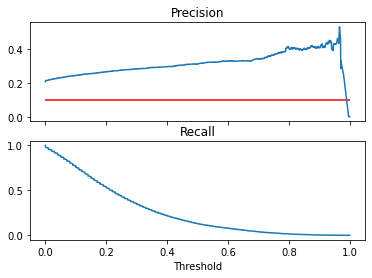

In [66]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.1,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.show()

In [73]:
min_index = [i for i, prec in enumerate(precision) if prec > 0.27][0]
print(min_index)
thresholds[min_index]

3232


0.2153230658230658

In [74]:
precision[min_index]

0.27000542810616235

In [75]:
recall[min_index]

0.5036235745497176

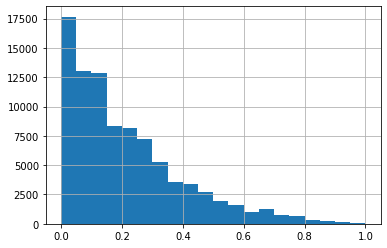

In [76]:
pd.Series(y_proba[:,1]).hist(bins=20, figsize=(6, 4));
# df.hist(column='SubjectAge', bins=20, figsize=(6, 4));

In [77]:
threshold = thresholds[min_index]
y_pred_threshold = pd.Series([True if p >= threshold else False for p in y_proba[:,1]]).to_numpy()

In [78]:
print(type(y_pred))
type(y_pred_threshold)

<class 'numpy.ndarray'>


numpy.ndarray

#### most important features

Feature ranking:
1. feature Longitude (0.240139)
2. feature Latitude (0.239861)
3. feature hour (0.200734)
4. feature month (0.163597)
5. feature Legislation_misuse of drugs act 1971 (section 23) (0.012227)
6. feature Legislation_police and criminal evidence act 1984 (section 1) (0.009881)
7. feature day_of_week_Thursday (0.009450)
8. feature day_of_week_Saturday (0.009417)
9. feature day_of_week_Friday (0.009295)
10. feature day_of_week_Wednesday (0.009143)
11. feature day_of_week_Tuesday (0.009130)


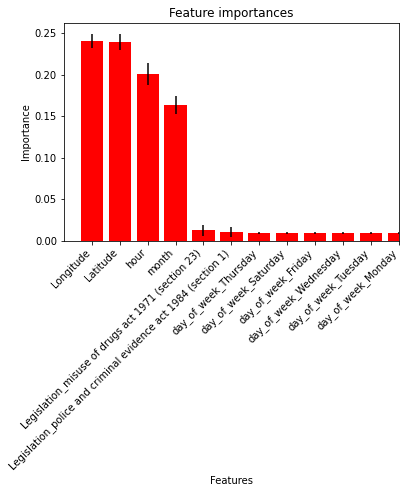

In [79]:
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
random_forest_step = pipeline.named_steps['randomforestclassifier']

onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()

## Formalizing client requirements

### 1 - Minimum 10% success rate for searches per station and search objective

In [82]:
def verify_global_success_rate(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    """
    
    precision = precision_score(y_true, y_pred, pos_label=1)
    is_satisfied = (precision >= min_success_rate)
    
    global_recall = recall_score(y_true, y_pred, pos_label=1)
    
    return is_satisfied, precision, global_recall

In [83]:
is_verified, success_rate, global_recall = verify_global_success_rate(y_test, y_pred_threshold)

print("Global Precision: {}".format((is_verified, success_rate)))
print("Global Recall: {}".format(global_recall))

Global Precision: (True, 0.27000542810616235)
Global Recall: 0.5036235745497176


In [84]:
def verify_success_rate_objective_station(X_test, y_true, y_pred, sensitive_column='Object of search', 
                                          min_success_rate=0.1, min_samples=50):
    """
    Verifies that success rate per station and search objective is higher than 10%
    """
    
#     exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks', 
#                  'detailed object of search unavailable','game or poaching equipment',
#                  'goods on which duty has not been paid etc.','evidence of wildlife offences',
#                  'crossbows','seals or hunting equipment']

    exclusion_list = ['articles for use in criminal damage','anything to threaten or harm anyone','fireworks',
                      'detailed object of search unavailable','game or poaching equipment',
                      'goods on which duty has not been paid etc.','evidence of wildlife offences',
                      'crossbows','seals or hunting equipment',
                      'firearms','evidence of offences under the act','psychoactive substances']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_list:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            precision_min = np.min(list(precisions.values()))

            if precision_min < min_success_rate:
                is_satisfied = False
                problematic_departments.append((department, precision_min, precisions))
            else:
                good_deparments.append((department, precision_min, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for department in departments:
        mask = (X_test['station'] == department)
        if np.sum(mask) > min_samples:
            global_precisions[department] = precision_score(y_true[mask], y_pred[mask])
            
    global_precisions_objective = {}
    for obj in sensitive_classes:
        mask = (X_test[sensitive_column] == obj)
        if np.sum(mask) > min_samples:
            global_precisions_objective[obj] = precision_score(y_true[mask], y_pred[mask])
    
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions,global_precisions_objective

In [85]:
is_satisfied, problematic_departments, good_deparments, ignored_departments,global_precisions, global_precisions_objective = verify_success_rate_objective_station(df_test, y_test, y_pred_threshold, min_success_rate=0.1)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic stations: {}".format(len(problematic_departments)))
    print("Num good stations: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    print("\nObject of search rates: {}".format(global_precisions_objective))
    print("\nStation rates: {}".format(global_precisions))


Requirement failed 😢
Num problematic stations: 18
Num good stations: 19
Num ignored departments: 1

Object of search rates: {'controlled drugs': 0.2932770970439588, 'stolen goods': 0.25673823663773415, 'offensive weapons': 0.1583803177857509, 'articles for use in criminal damage': 0.05451127819548872, 'anything to threaten or harm anyone': 0.1328125, 'article for use in theft': 0.1527331189710611, 'firearms': 0.1564245810055866, 'fireworks': 0.03571428571428571, 'evidence of offences under the act': 0.20512820512820512, 'psychoactive substances': 0.3356401384083045}

Station rates: {'merseyside': 0.2715325515568136, 'devon-and-cornwall': 0.2857142857142857, 'thames-valley': 0.1700348432055749, 'avon-and-somerset': 0.3109048723897912, 'greater-manchester': 0.2509433962264151, 'essex': 0.32076149425287354, 'kent': 0.2691489361702128, 'leicestershire': 0.1791907514450867, 'warwickshire': 0.316622691292876, 'staffordshire': 0.2899543378995434, 'lancashire': 0.0951188986232791, 'west-yorksh

In [86]:
problematic_departments

[('merseyside',
  0.07692307692307693,
  {'controlled drugs': 0.2816871099634173,
   'stolen goods': 0.1276595744680851,
   'offensive weapons': 0.07692307692307693,
   'article for use in theft': 0.15315315315315314}),
 ('thames-valley',
  0.06818181818181818,
  {'controlled drugs': 0.19961612284069097,
   'stolen goods': 0.1103448275862069,
   'offensive weapons': 0.10833333333333334,
   'article for use in theft': 0.06818181818181818}),
 ('kent',
  0.09090909090909091,
  {'controlled drugs': 0.2645273200346921,
   'stolen goods': 0.34536082474226804,
   'offensive weapons': 0.19402985074626866,
   'article for use in theft': 0.09090909090909091}),
 ('leicestershire',
  0.0,
  {'controlled drugs': 0.20137299771167047,
   'stolen goods': 0.034482758620689655,
   'offensive weapons': 0.1111111111111111,
   'article for use in theft': 0.0}),
 ('staffordshire',
  0.05405405405405406,
  {'controlled drugs': 0.31728045325779036,
   'stolen goods': 0.2926829268292683,
   'offensive weapons'

In [87]:
# good_deparments

In [88]:
print(min(global_precisions.values()))
max(global_precisions.values())

0.0951188986232791


0.4052757793764988

In [89]:
print(min(global_precisions_objective.values()))
max(global_precisions_objective.values())

0.03571428571428571


0.3356401384083045

### 2 - No police station should have a discrepancy bigger than 5% between the search success rate between protected classes (ethnicity, gender)

In [90]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column, max_diff=0.05, min_samples=50):
    """
    Verifies that no station has discrimination in between protected classes
    """
    exclusion_class = ['Other']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            if sensitive_class not in exclusion_class:
                mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
                if np.sum(mask) > min_samples:
                    precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions


In [91]:
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.05)

print("\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_precisions = verify_no_discrimination(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\n\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Ethnicity
Requirement failed 😢
Global rates: {'Black': 0.2732226258432797, 'White': 0.27044510603888705, 'Asian': 0.25854332067656194, 'Other': 0.2784688995215311}
Num problematic departments: 16
Num good departments: 14
Num ignored departments: 8
avg diff: 0.10629527533500717


Gender
Requirement failed 😢
Global rates: {'Male': 0.2722722407605616, 'Female': 0.24844139650872818, 'Other': 0.1724137931034483}
Num problematic departments: 17
Num good departments: 20
Num ignored departments: 1
avg diff: 0.09417805134392265


In [95]:
# good_deparments

### 3 - No police station should have a discrepancy bigger than x% between the Removal of more than just outer clothing rate between protected classes (age, ethnicity, gender)

In [96]:
def verify_removal_clothing(X_test, y_true, y_pred, sensitive_column, max_diff, min_samples=50):
    """
    Verifies that no station has discrepancy Removal of more than just outer clothing rate between 
    protected classes (age, ethnicity, gender)
    """
    exclusion_class = ['Other']
    exclusion_stations_removalclothes = ['cleveland', 'north-yorkshire', 'surrey']
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        if department not in exclusion_stations_removalclothes:
            removal_rate = {}
            for sensitive_class in sensitive_classes:
                if sensitive_class not in exclusion_class:
                    mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department) & (y_pred == 1)
                    if np.sum(mask) > min_samples:
                        removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==1))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])
                
        if len(removal_rate) > 1:    
            diff = np.max(list(removal_rate.values())) - np.min(list(removal_rate.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, removal_rate))
            else:
                good_deparments.append((department, diff, removal_rate))
        else:
            ignored_departments.append((department, None, []))
    
    global_removal_rate = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class) & (y_pred == True)
        if np.sum(mask) > min_samples:
            global_removal_rate[sensitive_class] = (np.sum(X_test[mask]['Removal of more than just outer clothing']==True))/(X_test[mask]['Removal of more than just outer clothing'].shape[0])

        
    return is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate


In [98]:
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Gender', 0.05)

print("\nGender")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Age range', 0.05)

print("\n\nAge range")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
    
    
is_satisfied, problematic_departments, good_deparments, ignored_departments, global_removal_rate = verify_removal_clothing(
    df_test, y_test, y_pred_threshold, 'Officer-defined ethnicity', 0.1)

print("\n\nEthnicity")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_removal_rate))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("Num ignored departments: {}".format(len(ignored_departments)))
    
    print("avg diff:", np.mean([p[1] for p in problematic_departments]))


Gender
Requirement failed 😢
Global rates: {'Male': 0.04369451614934206, 'Female': 0.046758104738154616}
Num problematic departments: 2
Num good departments: 21
Num ignored departments: 15
avg diff: 0.055150627564420664


Age range
Requirement failed 😢
Global rates: {'under 18': 0.02525747915644924, '18-24': 0.04747576061517887, 'over 34': 0.03830830524057616, '25-34': 0.05040237187632359}
Num problematic departments: 12
Num good departments: 24
Num ignored departments: 2
avg diff: 0.07379380558554206


Ethnicity
Requirement failed 😢
Global rates: {'Black': 0.10015568240788791, 'White': 0.03418237953467858, 'Asian': 0.05730065585088022, 'Other': 0.05454545454545454}
Num problematic departments: 8
Num good departments: 13
Num ignored departments: 17
avg diff: 0.1269596078135793
